In [1]:
!pip install torch torchvision

#MNIST Neural Network Models
1. Multi-Layer perceptron Model
2. Single Layer Convolution Neural Network Model
3. Multi-Layer Convolution Nerual Network Model

>3 different network models has implemented to train the machine 
>
>with a uniform dataset to determine the model with the best accuray. 




In [2]:

"""
baselines.py: contains all your network structure definition
including layers definition and forward pass function definition
"""
# PyTorch and neural network imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure, imshow, axis

# set the randomness to keep reproducible results
torch.manual_seed(0)
np.random.seed(0)

# input size to your mlp network
mlp_input_size = 784  # IMG size = (28,28) --> 28*28 = 784 total 
# final output size of your mlp network (output layer)
mlp_output_size = 10  # NUM classes 0 to 9 digits
mlp_hidden_size = 200
# num_epochs = 20  # number of times which the entire dataset is passed throughout the model
# batch_size = 32 # the size if input data took for one iteration
num_iter = 50
learning_rate = 0.04
batch_size = 32

#Multi-Layer Perceptron Model
---
Consists of one hidden layer and 1 output layer (all fully connected)



In [26]:

class BaselineMLP(nn.Module):
    def __init__(self):
        """
        A multilayer perceptron model
        Consists of one hidden layer and 1 output layer (all fully connected)
        """
        super(BaselineMLP, self).__init__()
        # a fully connected layer from input layer to hidden layer
        # mlp_input_size denotes how many input neurons you have
        # mlp_hiddent_size denotes how many hidden neurons you have
        self.fc1 = nn.Linear(mlp_input_size, mlp_hidden_size)
        # a fully connected layer from hidden layer to output layer
        # mlp_output_size denotes how many output neurons you have
        self.fc2 = nn.Linear(mlp_hidden_size, mlp_output_size)
        self.dropout = nn.Dropout2d(0.2)
        self.LeakyReLu = torch.nn.LeakyReLU()
    def forward(self, X):
        """
        Pass the batch of images through each layer of the network, applying 
        logistic activation function after hidden layer.
        """
        # pass X from input layer to hidden layer
        out = self.fc1(X)
        # apply an activation function to the output of hidden layer
        # out = torch.sigmoid(out)
        out = self.LeakyReLu(out)
        
        # pass output from hidden layer to output layer
        out = self.fc2(out)
        # return the feed forward output
        # you don't need to apply another activation function here if
        # the loss function you use already implement it for you
        return out

# Basic CNN model
---
> A basic convolutional neural network model for baseline comparison.

> Consists of one Conv2d layer, followed by 1 fully-connected (FC)
layer:
  conv1 -> fc1 (outputs)

In [4]:
class BaselineCNN(nn.Module):
    def __init__(self):
        """
        A basic convolutional neural network model for baseline comparison.
        Consists of one Conv2d layer, followed by 1 fully-connected (FC) layer:
        conv1 -> fc1 (outputs)
        """
        super(BaselineCNN, self).__init__()
        # define different layers
        # filter 1 : 5X5 kernel with 10 filters, stride 1 , zero-paddiing 2
        # tanh as non-linear activation
        self.conv1 = nn.Sequential(nn.Conv2d(1,10,5, stride=1, padding=2),nn.Tanh())
        self.fc1 = nn.Linear(28*28*10,10)

    def forward(self, X):
        """
        Pass the batch of images through each layer of the network, applying 
        non-linearities after each layer.

        Note that this function *needs* to be called "forward" for PyTorch to 
        automagically perform the forward pass.

        You may need the function "num_fc_features" below to help implement 
        this function

        Parameters: X --- an input batch of images
        Returns:    out --- the output of the network
        """
        # define the forward function
        X = self.conv1(X)
        X = X.view(-1, self.num_fc_features(X))
        X = self.fc1(X)
        out = X
        return out

    """
    Count the number of flattened features to be passed to fully connected layers
    Parameters: inputs --- 4-dimensional [batch x num_channels x conv width x conv height]
                            output from the last conv layer
    Return: num_features --- total number of flattened features for the last layer
    """

    def num_fc_features(self, inputs):

        # Get the dimensions of the layers excluding the batch number
        size = inputs.size()[1:]
        # Track the number of features
        num_features = 1

        for s in size:
            num_features *= s

        return num_features

# MyCNN Model
---


> A convolutional neural network model with more layers.



> Conv1 -> Multi-pool -> Conv2 -> Multi-pool -> Fully Connected Layer(FC1) -> FC2 ->Out

$$
n_{\textrm{out}} = \textrm{Floor}\left[\frac{n_{\textrm{in}}+2\textrm{pad}-\textrm{kernel size}}{\textrm{stride}}\right]
$$
where $n$ is the number of input features



In [5]:
"""
TODO: you may need to define your new neural network here
"""
class MyCNN(nn.Module):
    def __init__(self):

        super(MyCNN, self).__init__()
        # filter 1 : 5X5 kernel with 8 filters, stride 1 , zero-paddiing 2
        self.conv1 = nn.Sequential(nn.Conv2d(1,8,5, stride=1, padding=2),nn.LeakyReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(8,16,5, stride=1), nn.LeakyReLU())
        self.ReLU = nn.LeakyReLU()
        self.mp = nn.MaxPool2d((2,2))
        self.fc1 = nn.Linear(5*5*16,256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)
        
    def forward(self, X):
        # X = 32*32
        X = self.conv1(X) # x = 28*28*8 
        X = self.mp(X)    # x = 14*14*8
        X = self.conv2(X) # x = 10*10*16
        X = self.mp(X)    # x = 5*5*16
        X = X.view(-1, self.num_fc_features(X))
        X = self.ReLU(self.fc1(X))
        X = self.ReLU(self.fc2(X))
        X = self.fc3(X)
        out = X
        return out
    
    def num_fc_features(self, inputs):

        # Get the dimensions of the layers excluding the batch number
        size = inputs.size()[1:]
        # Track the number of features
        num_features = 1

        for s in size:
            num_features *= s

        return num_features

# Data Loader
---
> Read data from the specified training, validation and test data files.

> Input: The whole image



In [6]:

def read_data(trainFile, valFile, testFile):
    # trian, validation, and test data loader
    data_loaders = []

    # read training, test, and validation data
    for file in [trainFile, valFile, testFile]:
        # read data
        data = np.loadtxt(file)
        # digit images
        imgs = torch.tensor(data[:,:-1]).float()
        # divide each image by its maximum pixel value for numerical stability
        imgs = imgs / torch.max(imgs,dim=1).values[:,None]

        # labels for each image
        labels = torch.tensor(data[:,-1]).long()

        # if using CNN model, reshape each image:
        # [batch x num_channel x image width x image height]
        if not use_mlp:
            imgs = imgs.view(-1,1,28,28)

        # create dataset and dataloader, a container to efficiently load data in batches
        dataset = utils.TensorDataset(imgs,labels)
        dataloader = utils.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        data_loaders.append(dataloader)

    return data_loaders[0], data_loaders[1], data_loaders[2]

# Train Model #1: Multilayer Perceptron (MLP)

In [7]:
"""
Train Multilayer Perceptron (MLP)
Initialize MLP model --> define loss function --> define optimizer
--> train model with num_iter epochs --> pick the best model and return
    - Parameters:   train_loader --- the train dataloader
                    val_loader --- the validation dataloader
    - Return:       net --- the best trained MLP network with the lowest validation loss
                    avg_train_loss --- a list of averaged training loss of length num_iter
                    avg_val_loss --- a list of averaged validation loss of length num_iter
"""
def trainMLP(train_loader,val_loader):
    # average training loss, one value per iteration (averaged over all batches in one iteration)
    avg_train_loss = []
    # average validation loss, one value per iteration (averaged over all batches in one iteration)
    avg_val_loss = []
    # record the lowest validation loss, used to determine early stopping (best model)
    best_val_score = float('inf')
    
    net = BaselineMLP()
    # define loss function
    # define optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
    
    # define L2 regularization Lambda
    lamb = 0.0003
    
    # for each iteration, iteratively train all batches
    i = 0
    while i < num_iter:
        train_loss = 0
        # batch size
        size = 0
        for index,(imgs,labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = net(imgs)
            loss = loss_function(outputs, labels)
            
            # l2 reg
            l2_reg = torch.tensor(0.)
            for param in net.parameters():
                if len(param.shape) > 1:
                    l2_reg += torch.norm(param,p='fro')
                else:
                    l2_reg += torch.norm(param,p=2)
                  
            loss += lamb * l2_reg
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            size = index + 1
        
        avg_train_loss.append(train_loss/size)
        i=i+1
        
        # early stopping
        # save the best model with lowest validation loss and load it to do testing
        with torch.no_grad():
            val_loss = 0
            size = 0
            avg_loss = 0
            for index,(val_imgs, val_labels) in enumerate(val_loader):
                val_output = net(val_imgs)
                val_loss = loss_function(val_output,val_labels)
                avg_loss += val_loss.item()
                size = index+1
                
            avg_val_loss.append(avg_loss/size)
            if avg_loss < best_val_score:
                best_val_score = avg_loss
                torch.save(net.state_dict(), './model.pt')
                
    net.load_state_dict(torch.load('./model.pt')) 
    return net, avg_train_loss, avg_val_loss

#Train Model #2  Single Layer Convolutional Neural Network

In [8]:

"""
Train Baseline Convolutional Neural Network (CNN)
Initialize CNN model --> define loss function --> define optimizer
--> train model with num_iter epochs --> pick the best model and return
    - parameters:   train_loader --- the train dataloader
                    val_loader --- the validation dataloader
    - return:       net --- the best trained CNN network with the lowest validation loss
                    train_loss --- a list of training loss
"""
def trainCNN(train_loader,val_loader):
    # average training loss, one value per iteration (averaged over all batches in one iteration)
    avg_train_loss = []
    # average validation loss, one value per iteration (averaged over all batches in one iteration)
    avg_val_loss = []
    # record the lowest validation loss, used to determine early stopping (best model)
    best_val_score = float('inf')
    net = BaselineCNN()
    
    # define loss function
    # define optimizer
    # for each epoch, iteratively train all batches
    
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
    lamb = 0.0004
    i = 0
    while i < num_iter:
        
        # implement training and early stopping
        
        train_loss = 0
        size = 0
        for index,(images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = net(images)
            loss = loss_function(outputs,labels)
            # l2 reg
            l2_reg = torch.tensor(0.)
            for param in net.parameters():
                if len(param.shape) > 1:
                    l2_reg += torch.norm(param,p='fro')
                else:
                    l2_reg += torch.norm(param,p=2)
                  
            loss += lamb * l2_reg
            train_loss += loss
            size = index + 1
            loss.backward()
            optimizer.step()
        
        avg_train_loss.append(train_loss/size)
        i = i+1
        
        # Save the best model with lowest validation loss and load it to do testing
        with torch.no_grad():
            val_loss = 0
            size = 0
            for index,(val_imgs, val_labels) in enumerate(val_loader):
                val_output = net(val_imgs)
                loss = loss_function(val_output,val_labels)
                val_loss += loss.item()
                size = index+1
            
            val_loss = val_loss/size
            avg_val_loss.append(val_loss)
            if val_loss < best_val_score:
                best_val_score = val_loss
                torch.save(net.state_dict(), './model.pt')
            
            
    net.load_state_dict(torch.load('./model.pt'))         
    return net, avg_train_loss, avg_val_loss

#Train Model #3: My Multi-Layer Convolutional Neural Network (CNN)

In [9]:
def trainMyCNN(train_loader,val_loader):
    lamb = 0.0004
    mylr = 0.04
    # average training loss, one value per iteration (averaged over all batches in one iteration)
    avg_train_loss = []
    # average validation loss, one value per iteration (averaged over all batches in one iteration)
    avg_val_loss = []
    # record the lowest validation loss, used to determine early stopping (best model)
    best_val_score = float('inf')
    net = MyCNN()

    # define loss function
    # define optimizer
    # for each epoch, iteratively train all batches
    
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr = mylr)
    
    i = 0
    while i < num_iter:
        train_loss = 0
        size = 0
        for index,(images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = net(images)
            loss = loss_function(outputs,labels)
            
            # l2 reg
            l2_reg = torch.tensor(0.)
            for param in net.parameters():
                if len(param.shape) > 1:
                    l2_reg += torch.norm(param,p='fro')
                else:
                    l2_reg += torch.norm(param,p=2)
                  
            loss += lamb * l2_reg
            train_loss += loss
            size = index + 1
            loss.backward()
            optimizer.step()
        
        avg_train_loss.append(train_loss/size)
        i = i+1
            
        with torch.no_grad():
            val_loss = 0
            size = 0
            for index,(val_imgs, val_labels) in enumerate(val_loader):
                val_output = net(val_imgs)
                loss = loss_function(val_output,val_labels)
                val_loss += loss.item()
                size = index+1
            
            val_loss = val_loss/size
            avg_val_loss.append(val_loss)
            if val_loss < best_val_score:
                best_val_score = val_loss
                torch.save(net.state_dict(), './model.pt')
            
            
    net.load_state_dict(torch.load('./model.pt'))         
    return net, avg_train_loss, avg_val_loss

# Evaluation

In [10]:
"""
Evaluate the model, using unseen data features "X" and
corresponding labels "y".
Parameters: loader --- the test loader
            net --- the best trained network
Return: the accuracy on test set
"""
def evaluate(loader, net):
    total = 0
    correct = 0
    # use model to get predictions
    for X, y in loader:
        outputs = net(X)
        predictions = torch.argmax(outputs.data, 1)
        
        # total number of items in dataset
        total += y.shape[0]

        # number of correctly labeled items in dataset
        correct += torch.sum(predictions == y)

    # return fraction of correctly labeled items in dataset
    return float(correct) / float(total)

# Main

In [12]:
if __name__ == "__main__":

    # change this to False if you want to 
    # test your CNN model
    use_mlp = True
    use_my_cnn = False
    
    # load data from file
    train_loader, val_loader, test_loader = \
        read_data('/train.txt','/validate.txt', '/test.txt')


#Model #1 Accuracy and Loss function

Test accuracy: 0.89


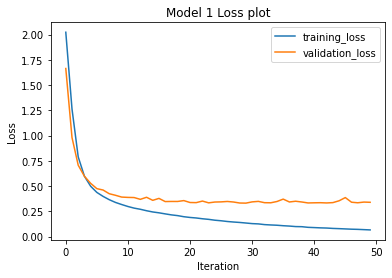

In [16]:
    use_mlp = True
    # load data from file
    train_loader, val_loader, test_loader = read_data('/train.txt','/validate.txt', '/test.txt')
    net, t_losses, v_losses = trainMLP(train_loader,val_loader)

    # evaluate model on validation data

    accuracy = evaluate(test_loader, net)  
    print("Test accuracy: {}".format(accuracy))

    # plot losses
    plt.plot(t_losses)
    plt.plot(v_losses)
    plt.legend(["training_loss","validation_loss"])
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Model 1 Loss plot")
    plt.show()
    use_mlp = False

#Model #2 Accuracy and Loss function

Test accuracy: 0.901


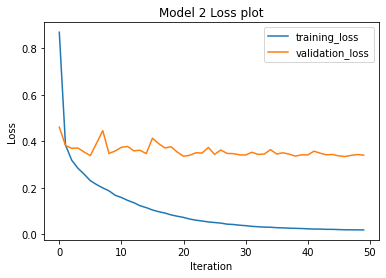

In [23]:
    # load data from file
    train_loader, val_loader, test_loader = read_data('/train.txt','/validate.txt', '/test.txt')
    net, t_losses, v_losses = trainCNN(train_loader,val_loader)

    # evaluate model on validation data

    accuracy = evaluate(test_loader, net)  
    print("Test accuracy: {}".format(accuracy))
    # plot losses
    plt.plot(t_losses)
    plt.plot(v_losses)
    plt.legend(["training_loss","validation_loss"])
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Model 2 Loss plot")
    plt.show()


#Model #3 Accuracy and Loss function

Test accuracy: 0.955


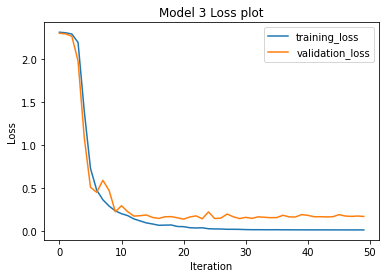

In [25]:
    net, t_losses, v_losses = trainMyCNN(train_loader,val_loader)
    
    # evaluate model on validation data
    accuracy = evaluate(test_loader, net)  
    print("Test accuracy: {}".format(accuracy))
    
    # plot losses
    plt.plot(t_losses)
    plt.plot(v_losses)
    plt.legend(["training_loss","validation_loss"])
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Model 3 Loss plot")
    plt.show()

#Conclusion


---

The CNN increased the accuracy by preserving the dimensions at each layers of the network as it proceed forward. The main part of implementation was adding more layers
to the network. The architecture of network consists of 2 convolution layers and 2 maxpooling layers, 3 fully connected layers, and ReLU functions. The kernel size and the
number of filtering of two convolution were used as follow; 5x5x10 and 5x5x16. By this
implementation, the network produces more distinct data than the those from the previous
models. Moreover, 3 fully connected layers decreased the dimensions of data gradually